## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

## 1. Carga datos y representa la serie

In [65]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [66]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates = ['date'])
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   value   144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [68]:
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [69]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates = ['date'], index_col='date')
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


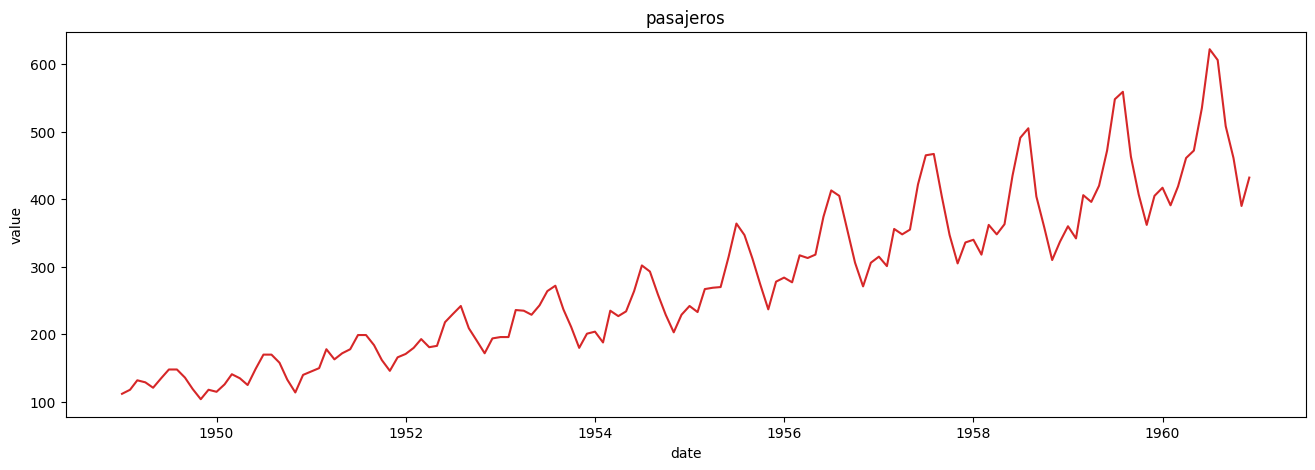

In [70]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='date', ylabel='value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='pasajeros') 

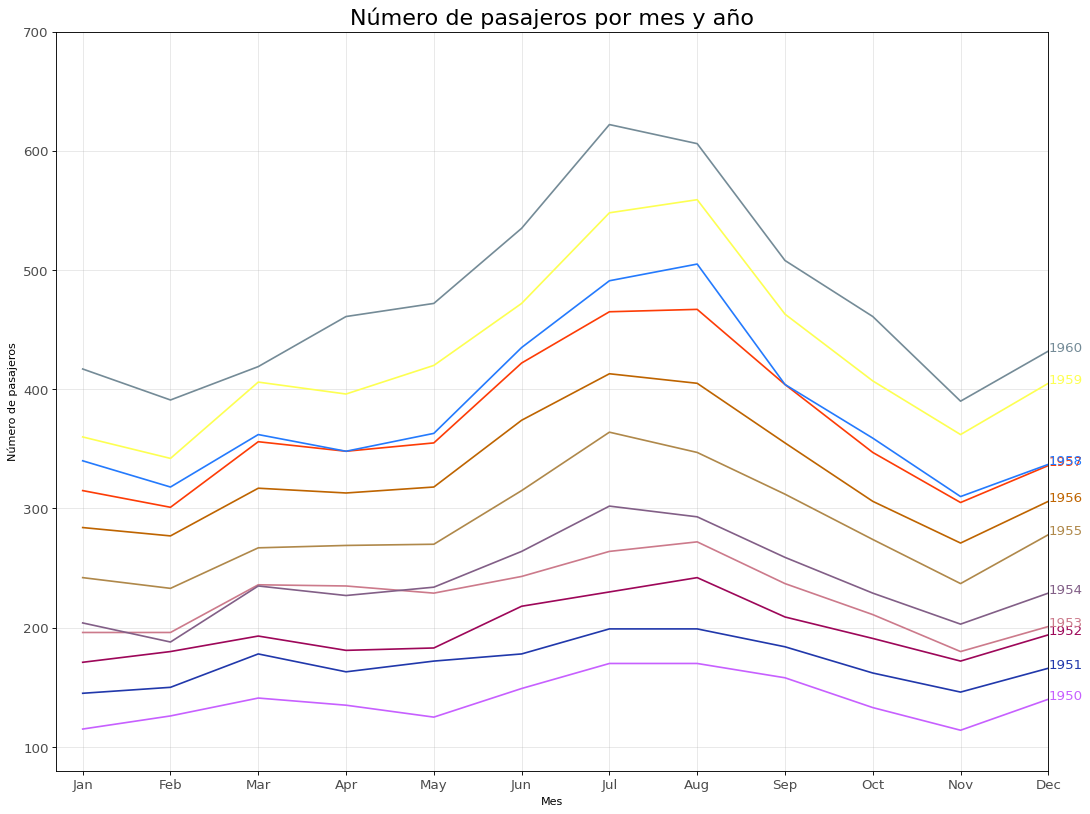

In [71]:
# Cargar datos
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Añadir columnas de año y mes
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.strftime('%b')
years = df['year'].unique()

# Preparar colores
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Dibujar gráfica
plt.figure(figsize=(16, 12), dpi=80)
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'value', data=df[df.year == y], color=mycolors[i], label=y)
        plt.text(
            11,  # Posicionar el texto en el último mes
            df[df.year == y]['value'].iloc[-1],
            str(y),
            fontsize=12,
            color=mycolors[i]
        )

# Ajustar ejes y etiquetas
plt.gca().set(xlim=(-0.3, 11), ylim=(80, 700), ylabel='Número de pasajeros', xlabel='Mes')
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(range(12), df['month'].unique(), fontsize=12, alpha=.7)  # Etiquetas de los meses
plt.title("Número de pasajeros por mes y año", fontsize=20)
plt.grid(alpha=0.3)
plt.show()

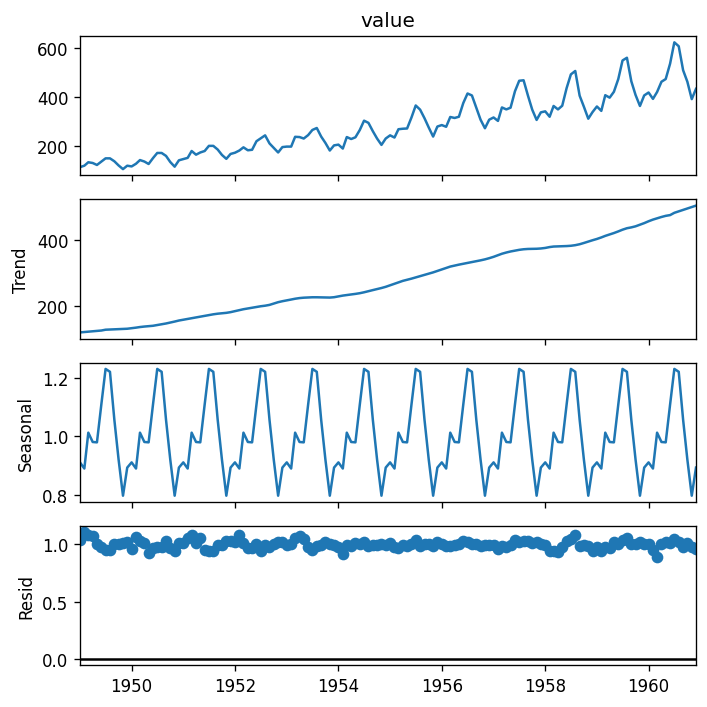

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Import Data
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul.plot();

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

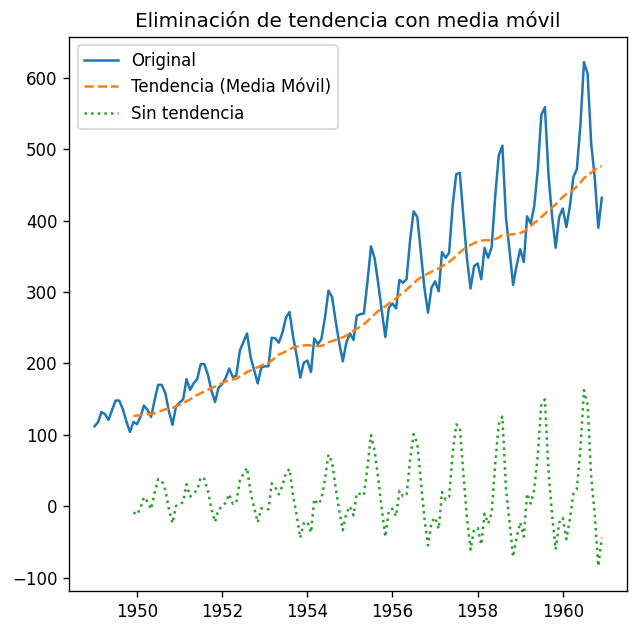

In [73]:
# Suavizado por media móvil
rolling_mean = df['value'].rolling(window=12).mean()
df['detrended_ma'] = df['value'] - rolling_mean

# Visualizar
plt.plot(df['value'], label='Original')
plt.plot(rolling_mean, label='Tendencia (Media Móvil)', linestyle='--')
plt.plot(df['detrended_ma'], label='Sin tendencia', linestyle=':')
plt.legend()
plt.title("Eliminación de tendencia con media móvil")
plt.show()

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [74]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba de Dickey-Fuller aumentada
result = adfuller(df['value'])

# Mostrar los resultados
print("Estadístico ADF:", result[0])
print("p-valor:", result[1])
print("Valores críticos:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpretación del p-valor
if result[1] > 0.05:
    print("\nLa serie NO es estacionaria (p-valor > 0.05).")
else:
    print("\nLa serie es estacionaria (p-valor <= 0.05).")


Estadístico ADF: 0.8153688792060482
p-valor: 0.991880243437641
Valores críticos:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598

La serie NO es estacionaria (p-valor > 0.05).


### ¿Qué significa "Stationary"?

En el análisis de series temporales, **stationary** (o estacionariedad) significa que las propiedades estadísticas de la serie, como la **media**, la **varianza** y la **autocorrelación**, **no cambian con el tiempo**.

Una serie temporal estacionaria cumple las siguientes condiciones:
1. **Media constante**: La serie no muestra una tendencia creciente o decreciente.
2. **Varianza constante**: Las fluctuaciones alrededor de la media son uniformes a lo largo del tiempo.
3. **Autocorrelación constante**: Las correlaciones entre los valores en diferentes momentos no dependen del tiempo.

#### Ejemplo de series estacionarias y no estacionarias:
- **Estacionaria**: Variaciones alrededor de un valor promedio constante, como los valores diarios de temperatura en un entorno controlado.
- **No estacionaria**: Series con tendencias crecientes, decrecientes o con estacionalidad, como las ventas que aumentan cada diciembre.

#### ¿Por qué es importante?
La mayoría de los modelos para series temporales, como ARIMA, asumen que la serie es estacionaria. Si no lo es, suelen requerir transformaciones (como diferenciación o logaritmos) para estabilizar las propiedades estadísticas de la serie.

#### Cómo verificar si una serie es estacionaria:
1. Visualmente: Observar si hay una tendencia o cambios en la varianza.
2. Estadísticamente: Usar pruebas como **ADF (Dickey-Fuller)** o **KPSS** para verificar si la serie es estacionaria.


## 4. Aplica una transformación logarítmica

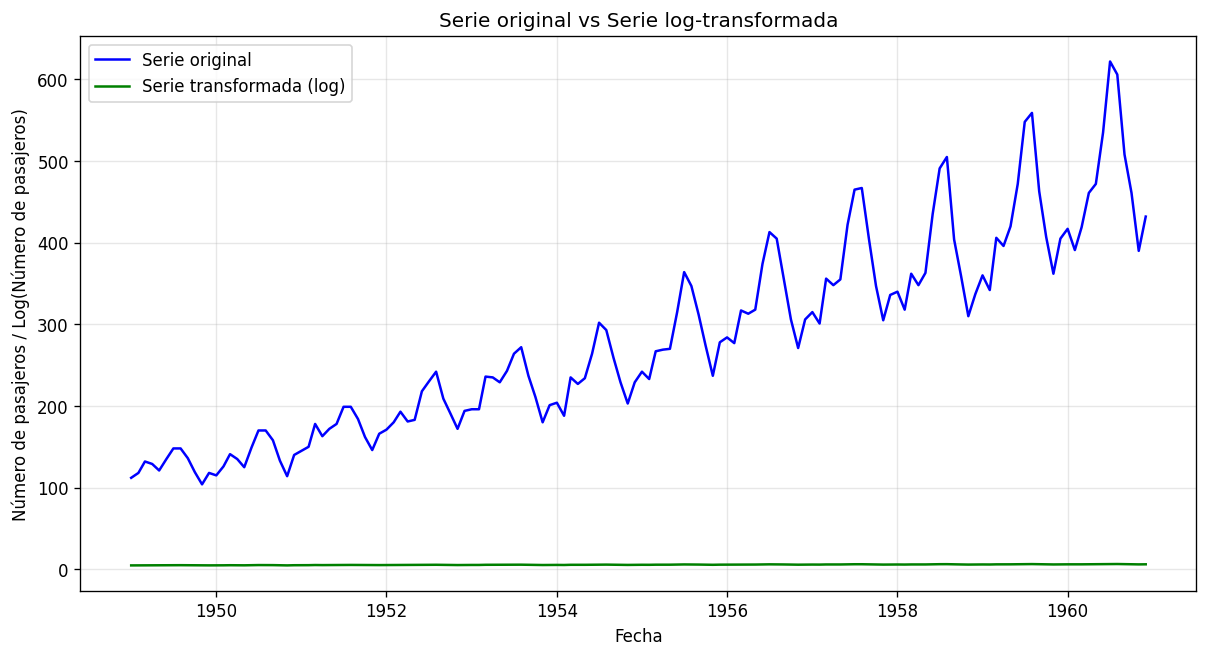

In [75]:
# Aplicar la transformación logarítmica
df['Log Value'] = np.log(df['value'])

# Graficar la serie original y la transformada
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Serie original', color='blue')
plt.plot(df.index, df['Log Value'], label='Serie transformada (log)', color='green')
plt.title('Serie original vs Serie log-transformada')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros / Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


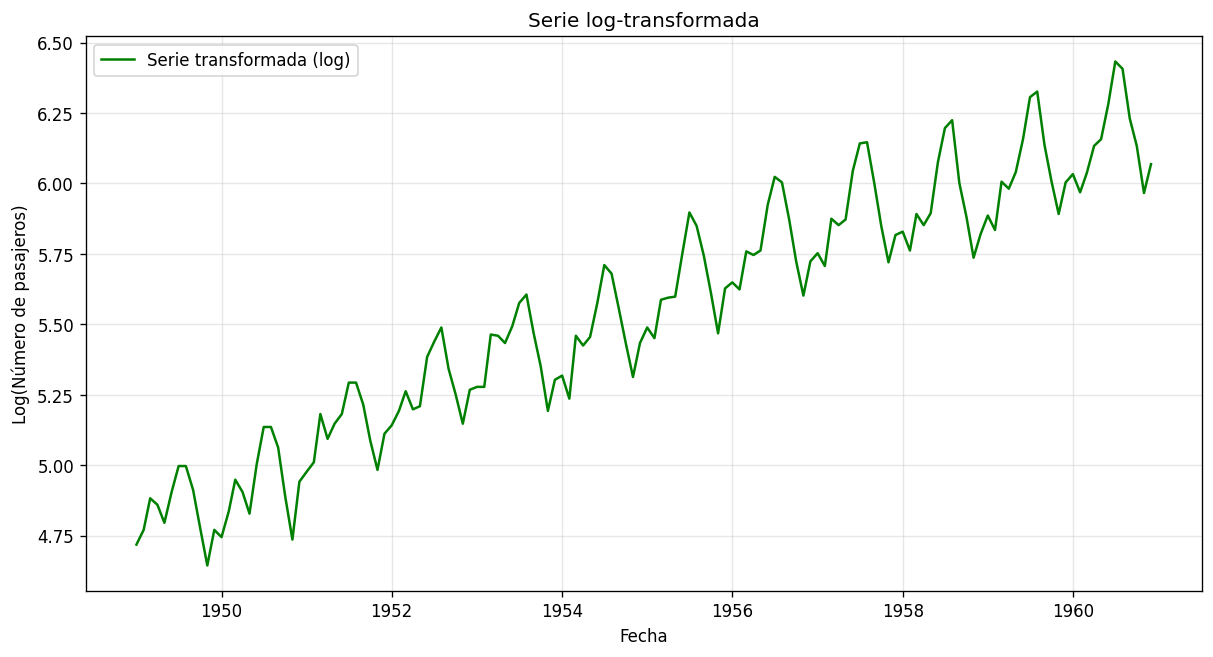

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Log Value'], label='Serie transformada (log)', color='green')
plt.title('Serie log-transformada')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



## 5. Divide en train y test. Guarda 20 muestras para test.

Tamaño del conjunto de entrenamiento: 124
Tamaño del conjunto de prueba: 20


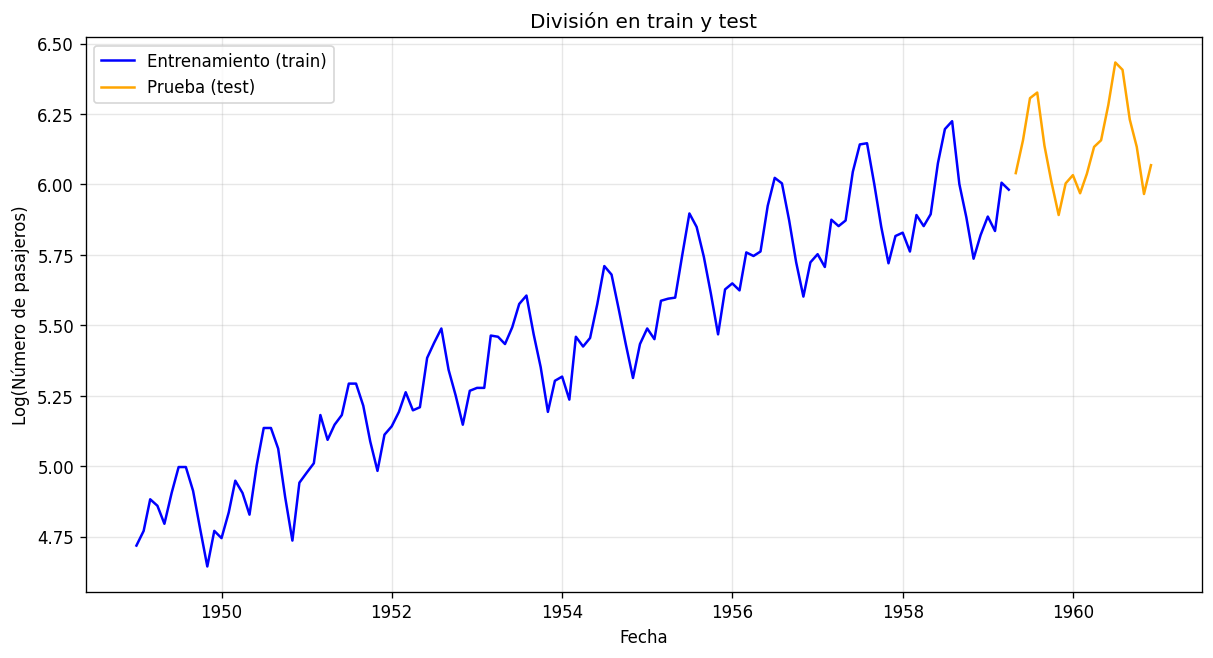

In [77]:
# Dividir los datos en train y test
train = df['Log Value'][:-20]  # Todas las muestras excepto las últimas 20
test = df['Log Value'][-20:]  # Últimas 20 muestras para prueba

# Mostrar tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de prueba:", len(test))

# Visualizar la división
plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento (train)', color='blue')
plt.plot(test, label='Prueba (test)', color='orange')
plt.title('División en train y test')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 6. Crea tu primer modelo ARIMA

c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE (Error absoluto medio): 0.0345
RMSE (Raíz del error cuadrático medio): 0.0382


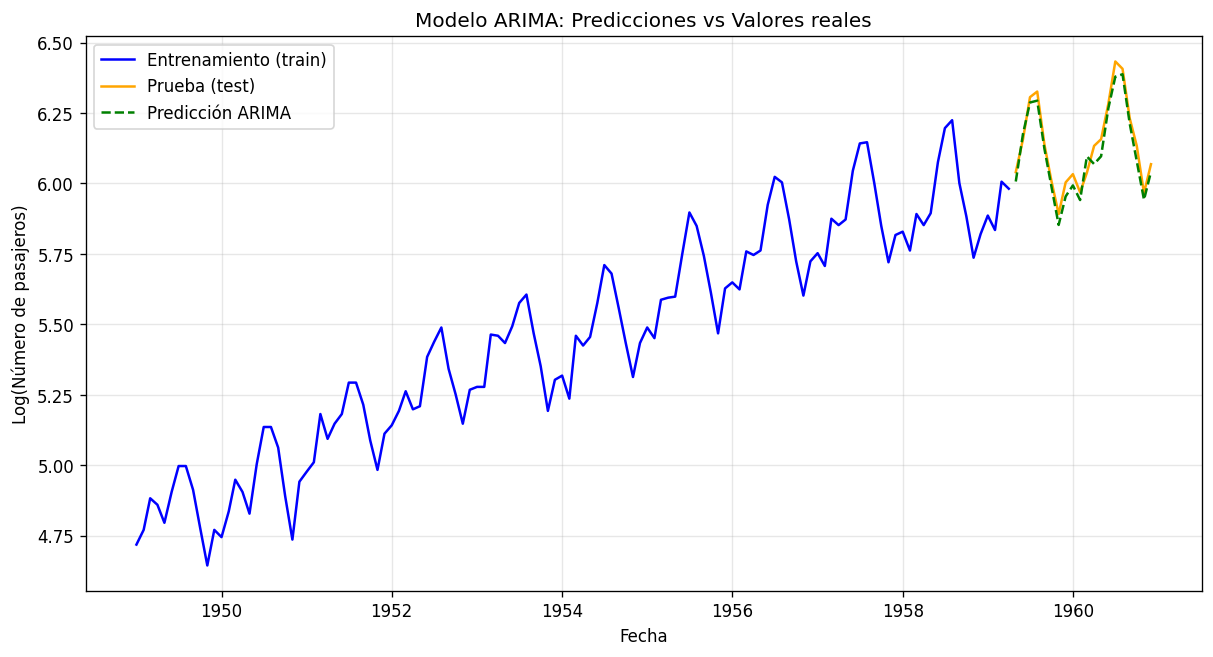

In [78]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Definir y ajustar el modelo ARIMA
# Nota: Usamos (p=1, d=1, q=1) como valores iniciales; puedes ajustarlos según sea necesario.
model = ARIMA(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit()

# Predicción en el conjunto de prueba
forecast = fitted_model.forecast(steps=len(test))

# Calcular métricas de rendimiento
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE (Error absoluto medio): {mae:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento (train)', color='blue')
plt.plot(test, label='Prueba (test)', color='orange')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='green', linestyle='--')
plt.title('Modelo ARIMA: Predicciones vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 7. Representa en una gráfica los datos de test y tus predicciones.

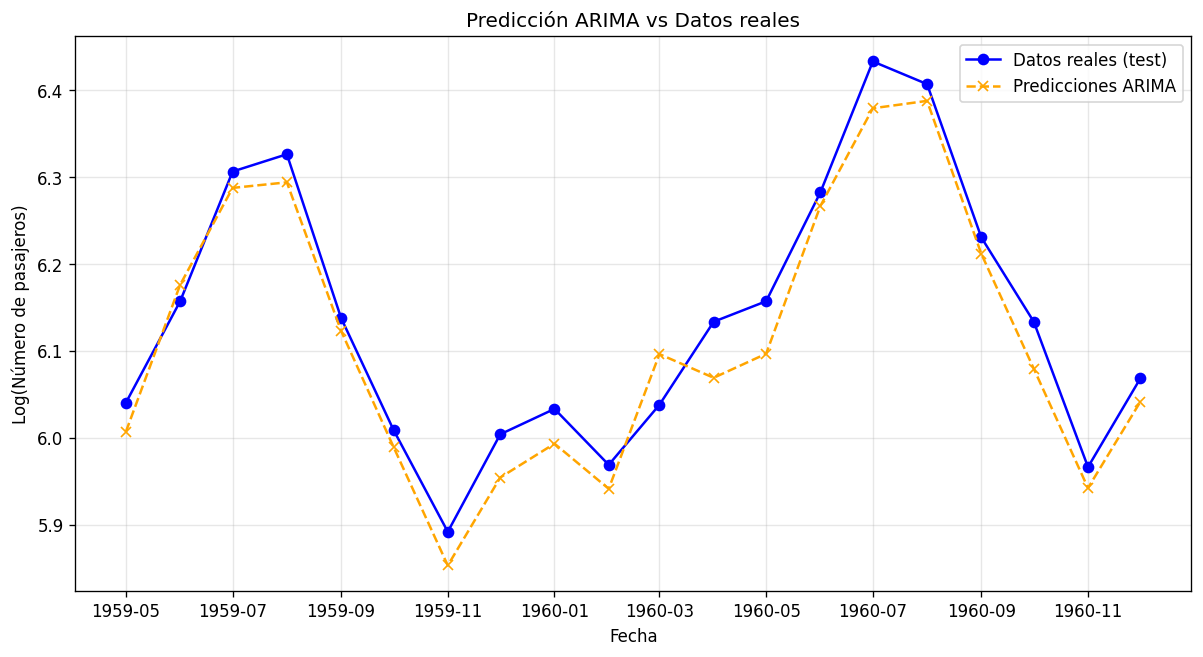

In [79]:
# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Datos reales (test)', color='blue', marker='o')
plt.plot(test.index, forecast, label='Predicciones ARIMA', color='orange', linestyle='--', marker='x')
plt.title('Predicción ARIMA vs Datos reales')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 8. Prueba otros modelos, a ver qué performance presentan.

c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA - MAE: 0.0345, RMSE: 0.0382


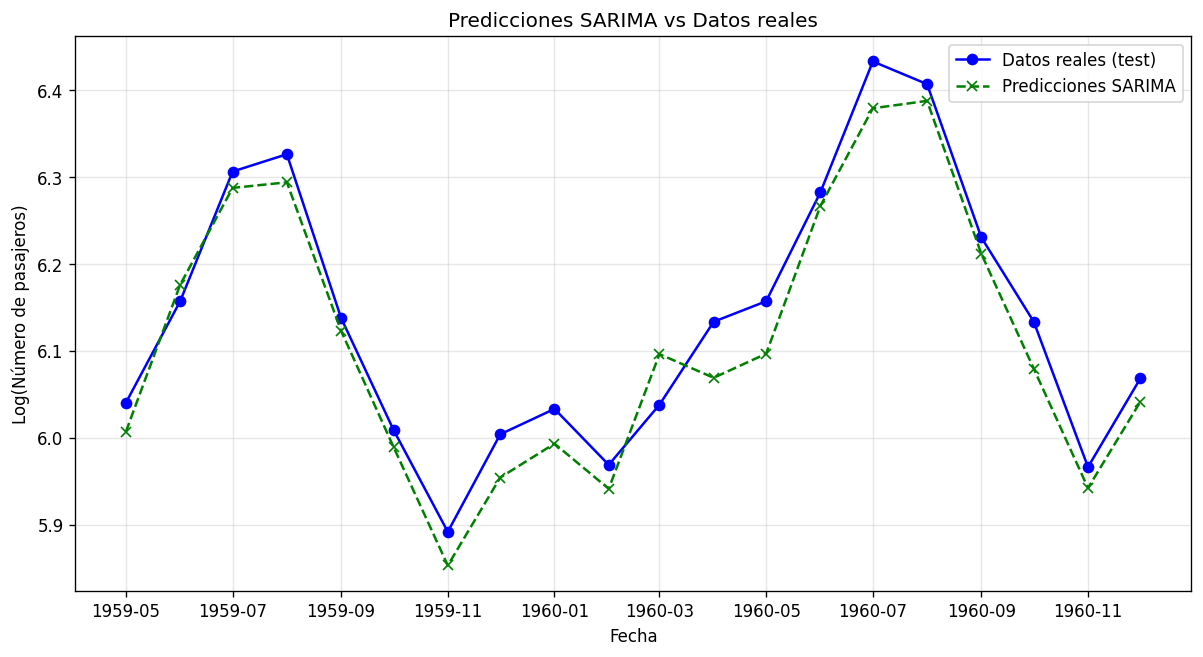

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted = sarima_model.fit()

# Predicciones
sarima_forecast = sarima_fitted.forecast(steps=len(test))

# Métricas de evaluación
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print(f"SARIMA - MAE: {sarima_mae:.4f}, RMSE: {sarima_rmse:.4f}")

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Datos reales (test)', color='blue', marker='o')
plt.plot(test.index, sarima_forecast, label='Predicciones SARIMA', color='green', linestyle='--', marker='x')
plt.title('Predicciones SARIMA vs Datos reales')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Si tienes variables externas que puedan influir en los pasajeros (por ejemplo, datos de clima, eventos, etc.), SARIMAX puede incorporarlas. Aquí usaremos un ejemplo ficticio de variable exógena.

In [81]:
# Crear una variable exógena de ejemplo (puede ser cualquier dato externo)
np.random.seed(42)
df['Exogenous'] = np.random.normal(0, 1, len(df))

# Dividir en entrenamiento y prueba
exog_train = df['Exogenous'][:-20].values.reshape(-1, 1)
exog_test = df['Exogenous'][-20:].values.reshape(-1, 1)


c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX - MAE: 0.0348, RMSE: 0.0388


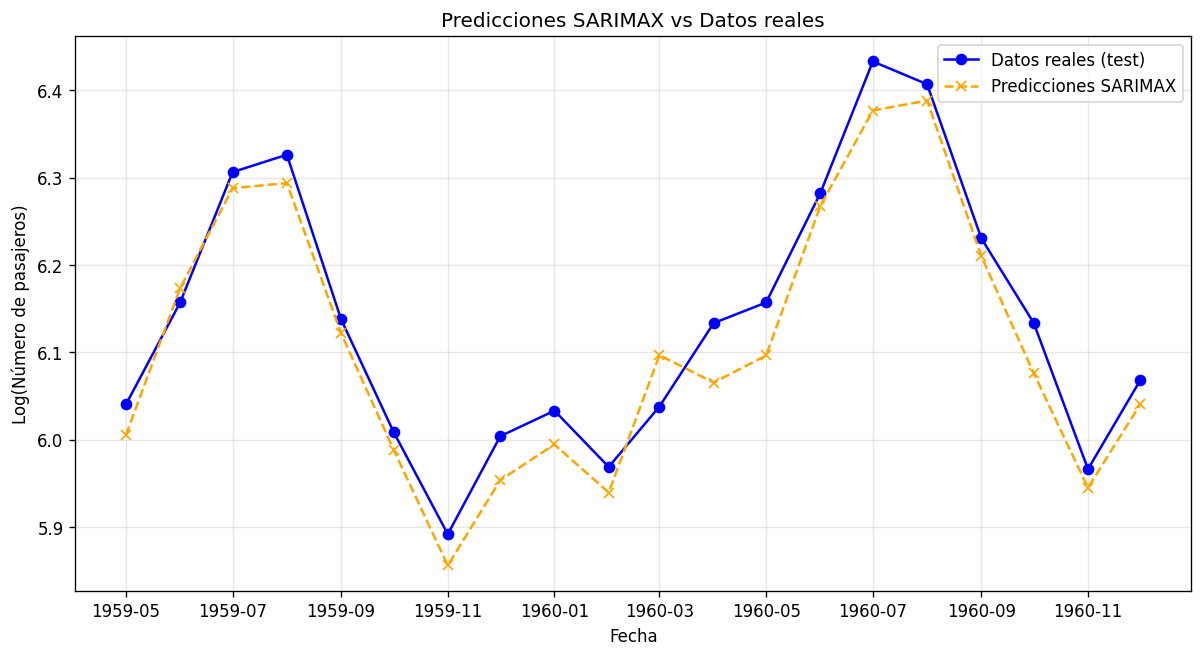

In [82]:
# Ajustar el modelo SARIMAX con la variable exógena
sarimax_model = SARIMAX(train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fitted = sarimax_model.fit()

# Predicciones
sarimax_forecast = sarimax_fitted.forecast(steps=len(test), exog=exog_test)

# Métricas de evaluación
sarimax_mae = mean_absolute_error(test, sarimax_forecast)
sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_forecast))

print(f"SARIMAX - MAE: {sarimax_mae:.4f}, RMSE: {sarimax_rmse:.4f}")

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Datos reales (test)', color='blue', marker='o')
plt.plot(test.index, sarimax_forecast, label='Predicciones SARIMAX', color='orange', linestyle='--', marker='x')
plt.title('Predicciones SARIMAX vs Datos reales')
plt.xlabel('Fecha')
plt.ylabel('Log(Número de pasajeros)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


| **Modelo**   | **Estacionalidad** | **Variables externas** | **Uso principal**                                   |
|--------------|--------------------|-------------------------|----------------------------------------------------|
| **ARIMA**    | No                 | No                      | Series no estacionales o series diferenciadas      |
| **SARIMA**   | Sí                 | No                      | Series con estacionalidad clara                   |
| **SARIMAX**  | Sí                 | Sí                      | Series con estacionalidad y factores externos     |

### Ejemplo práctico:

- **ARIMA**:
  - Ventas diarias de un producto sin picos recurrentes claros.

- **SARIMA**:
  - Tráfico de pasajeros, con picos cada diciembre y julio.

- **SARIMAX**:
  - Tráfico de pasajeros afectado por feriados o precios del combustible.
